In [1]:
!pip install pandas matplotlib seaborn stellar-sdk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 37.3 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 47.5 MB/s eta 0:00:0000:0100:01
  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
  Using cached stellar_sdk-11.1.0-py3-none-any.whl (693 kB)
  Using cached pytz-2024.2-py2.py3-none-any.whl (508 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 51.9 MB/s eta 0:00:00a 0:00:01
  Using cached tzdata-2024.2-py2.py3-none-any.whl (346 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 53.7 MB/s eta 0:00:00a 0:00:01
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 48.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.3/253.3 KB 23.3 MB/s eta 0:00:00
  Using cached pyparsing-3.2.0-py3-none-any.whl (106 kB)
  Using cached toml-0.10.2-py2.py3-none-any.whl (16 

In [7]:
# @title Setup
import pandas as pd
from stellar_sdk import Server

# Inicialize o servidor Horizon para cada rede
mainnet_server = Server("https://horizon.stellar.org")
testnet_server = Server("https://horizon-testnet.stellar.org")

df = pd.read_csv('./dev30k-03.csv')

df.head()
df = df.rename(columns={
    'Carimbo de data/hora': 'submission_datetime',
    'Qual sua Chave Pública?': 'account_id',
    'ID do Contrato': 'contract_id',
    'Hash do Deploy do Contrato': 'deploy_tx_hash',
    'Qual rede?': 'network'
})

# Analise dos Dados

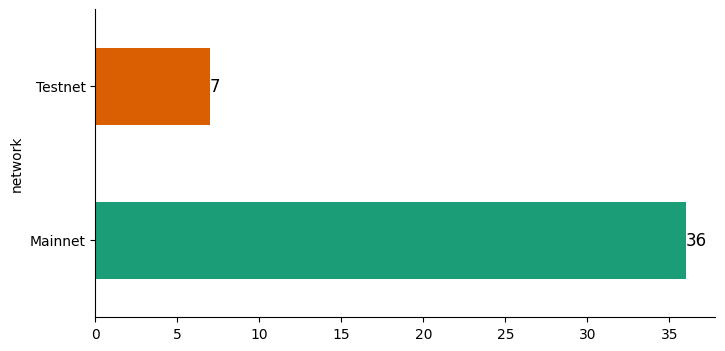

In [9]:
# @title Deploy Network

import matplotlib.pyplot as plt
import seaborn as sns

# Separação dos dados por rede
mainnet_df = df[df["network"] == "Mainnet"].reset_index(drop=True)
testnet_df = df[df["network"] == "Testnet"].reset_index(drop=True)

# Agrupamento e criação do gráfico
counts = df['network'].value_counts()
total = counts.sum()

fig, ax = plt.subplots(figsize=(8, 4))
counts.plot(kind='barh', color=sns.color_palette('Dark2'), ax=ax)

# Remoção das bordas superior e direita
ax.spines[['top', 'right']].set_visible(False)

# Adiciona o número individual ao lado de cada barra
for index, value in enumerate(counts):
    ax.text(value, index, str(value), va='center', ha='left', fontsize=12)

# Exibir o gráfico
plt.show()


In [10]:
# @title Get deploy datetime

import pandas as pd

# Função para buscar o timestamp de criação do contrato e o tipo de operação
def get_operation_details(transaction_hash, account_id, network):
    server = mainnet_server if network == "Mainnet" else testnet_server
    ops = {}
    try:
        # Obtenha todas as operações associadas à transação
        ops = server.operations().for_transaction(transaction_hash).call()['_embedded']['records']
    except Exception as e:
        print(f"🚨 Error fetching operation details for {transaction_hash}: {str(e)}")
        return None, None
    for op in ops:
        # Verifique se a operação é feita pela account_id
        is_correct_account = account_id == op.get('source_account', False)
        if is_correct_account:
            # Retorne o timestamp e o tipo de operação
            return op['created_at'], op.get('type', 'Unknown')
    print(f"⚠️ No matching operation found for {transaction_hash} and account {account_id}")
    return None, None

# Função para processar cada DataFrame (mainnet e testnet)
def process_deploy_details(df, network_name):
    deploy_timestamps = []
    operation_types = []

    for _, row in df.iterrows():
        timestamp, op_type = get_operation_details(
            row['deploy_tx_hash'],
            row['account_id'],
            network_name
        )
        deploy_timestamps.append(timestamp)
        operation_types.append(op_type)

    # Adiciona as colunas ao DataFrame
    df['deploy_timestamp'] = pd.to_datetime(deploy_timestamps)
    df['op_type'] = operation_types
    df['network'] = network_name  # Adiciona a informação da rede para diferenciar depois
    return df

# Processar os DataFrames mainnet e testnet
mainnet_df = process_deploy_details(mainnet_df, "Mainnet")
testnet_df = process_deploy_details(testnet_df, "Testnet")

# Concatenar os DataFrames mainnet e testnet
final_df = pd.concat([mainnet_df, testnet_df]).reset_index(drop=True)

🚨 Error fetching operation details for 19da1a600b2119d4eb6f01c238583ba7d0b6bd628fcce05b5594a5e39fb5d18a: <Response [status_code=404, text={
  "type": "https://stellar.org/horizon-errors/not_found",
  "title": "Resource Missing",
  "status": 404,
  "detail": "The resource at the url requested was not found.  This usually occurs for one of two reasons:  The url requested is not valid, or no data in our database could be found with the parameters provided."
}, headers={'Date': 'Wed, 20 Nov 2024 21:07:06 GMT', 'Content-Type': 'application/problem+json; charset=utf-8', 'Content-Length': '322', 'Connection': 'keep-alive', 'Cache-Control': 'no-cache, no-store, max-age=0', 'Vary': 'Origin'}, url=https://horizon.stellar.org/transactions/19da1a600b2119d4eb6f01c238583ba7d0b6bd628fcce05b5594a5e39fb5d18a/operations]>
⚠️ No matching operation found for 33a1171522d8616ab7682f278f48b0dbc00bb6dd9427f41e1d94c27b492e1f29 and account GAFASLN5AWEKSDNXLRUH525N2FSNTBFLFG53EPUEOKRQCWUI2BLT5JES
🚨 Error fetchin

In [11]:
df.head()

,submission_datetime,account_id,contract_id,deploy_tx_hash,network
0,11/11/2024 20:19:09,GCPRODSERXDJAUGWF7765HOVMNJBA4DA4GVMXACH4PW3LH...,CC3KNLQRTZD2FROMHS4FBXERJ7VRWDNVGYE6ASAYC4QUL4...,9dafbc7080eae54c8102819de53537362d69438234a34e...,NaN
1,11/11/2024 20:19:57,GCBKAQ6YPZZ7B54QVHL5RYNVWO2ELPBOO235KKJYTD4SHB...,CBEPJWFMU7B2CTTBY7AIN7WLW5LDN7SHVHDTL6JIPRSA2U...,b3486edbe3a6d5b3f2f98a975d940186e9e04e47006f6f...,NaN
2,11/11/2024 20:20:19,GCMUASIHX2JBY2FJNRTXVEGDYNCWWZHI7CLE7DCYIYRGPK...,CAIF7ECHHPG4RRGKLHYX3I5LZXGGEBWGVRH6RASBGELJMF...,59f3234e0c6f20e17b3b22a84bdd2554f62a884e5896f7...,NaN
3,11/11/2024 20:24:36,GBBIVZN5N7EMYMQHZL4ME64GWDM5REJDLFBDET7KLIIA6G...,CBWIJGH5TELGKZ55PS5VCXD2WJDO6A2KMJRGYXIMLJOBDQ...,baf55492460241821510620563b66821100d704cf745ac...,NaN
4,11/11/2024 20:27:16,GAHIS47WJTR6NXH5UQESWE2E7JED52YLORRVPFHL3QFC36...,CDBYWEIOBLWXTI5ULTUHWSF4HKJ52X2FU62M7VGL6YA3UC...,cbb53659d473b477db573f6f096c5a2dce94c9e6c8bc2d...,NaN


In [12]:
final_df.head()

,submission_datetime,account_id,contract_id,deploy_tx_hash,network,deploy_timestamp,op_type
0,12/11/2024 10:22:46,GCBSD5LCZLKWF7L7ADHTBZAIA7NQQMTUDXFQ5LNNWCIVPJ...,CDLZFC3SYJYDZT7K67VZ75HPJVIEUVNIXF47ZG2FB2RMQQ...,cafb66c4a41980ddc671c3ad976b0abc5b5366f16a33ce...,Mainnet,2024-11-09 14:40:47+00:00,manage_data
1,11/11/2024 21:21:49,GB5UBWORACGMEHWLBN4CQMTOGPALCSOXTQLX4K7HU3SQE4...,CAENH255E2GZID5PYE2327BPFRIWYSJUJ54JLBYLWRQ2EG...,28cf956b9f6395ea23cde7f4af0f6653a6b69e6624ca8d...,Mainnet,2024-11-11 17:11:11+00:00,invoke_host_function
2,11/11/2024 21:21:52,GDSGKFLEGCRLWEAHSX7DWECMWLSMUR7SFFP5P2RLP5FW26...,CDVVRRZEDEIPNB6S6STOIU4RDJTRJXT2PTODWACBTAV75M...,229473b23f54f8caaf768b4ffcc179e150cc225c7136f4...,Mainnet,2024-11-10 13:22:39+00:00,invoke_host_function
3,11/11/2024 21:22:05,GBXK6PFMNECA4TR74U4VPVDOQGJFWBGMU4UD2LYX2Z3ZFD...,CCLUBHBFRKICMNQ57R3YYOAYNOKFAJLL7P23XONSPQ4OEG...,19da1a600b2119d4eb6f01c238583ba7d0b6bd628fcce0...,Mainnet,NaT,None
4,11/11/2024 21:22:16,GAFASLN5AWEKSDNXLRUH525N2FSNTBFLFG53EPUEOKRQCW...,CCR5YL6G2Y7OJNPL7JSEG3RH2ETGSLKXBGSZFS5JMSDXPT...,33a1171522d8616ab7682f278f48b0dbc00bb6dd9427f4...,Mainnet,NaT,None


In [13]:
# @title Clean Data
# Concatenar os DataFrames mainnet e testnet
final_df = pd.concat([mainnet_df, testnet_df]).reset_index(drop=True)

# Remove linhas onde op_type não é 'invoke_host_function'
deploy_contract_df = final_df[final_df['op_type'] == 'invoke_host_function']

# Remove colunas
deploy_contract_df = deploy_contract_df[['submission_datetime', 'account_id', 'contract_id', 'deploy_tx_hash', 'network', 'deploy_timestamp']]
df = deploy_contract_df

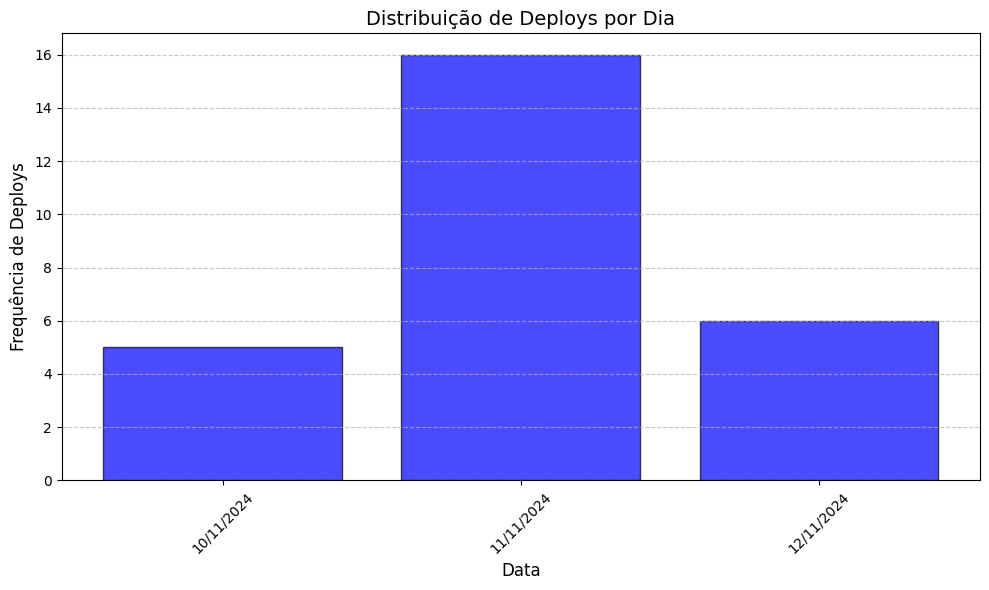

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Converta a coluna 'deploy_timestamp' para datetime, se necessário
df['deploy_timestamp'] = pd.to_datetime(df['deploy_timestamp'])

# Agrupe os dados por dia
df['deploy_date'] = df['deploy_timestamp'].dt.date

# Ordenar os dados por data
deploy_counts = df['deploy_date'].value_counts().sort_index()

# Criação do histograma
plt.figure(figsize=(10, 6))
plt.bar(deploy_counts.index, deploy_counts.values, color='blue', edgecolor='black', alpha=0.7)

# Configurações do gráfico
plt.title('Distribuição de Deploys por Dia', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Frequência de Deploys', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Formatando as datas no eixo x
formatted_dates = [date.strftime("%d/%m/%Y") for date in deploy_counts.index]
plt.xticks(deploy_counts.index, formatted_dates, rotation=45, fontsize=10)

# Exibição do gráfico
plt.tight_layout()
plt.show()

In [ ]:
# @title Estimate Gas Fee [Boxplot Outliers]

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter

from stellar_sdk import Keypair, Network, SorobanServer, TransactionBuilder, scval, xdr
from stellar_sdk.soroban_rpc import GetTransactionStatus
from itertools import cycle


# Set up sender account and servers
PRIVATE_KEY = "MAINNET_PRIVATE_KEY"
sender_keypair = Keypair.from_secret(PRIVATE_KEY)

soroban_mainnet_server = SorobanServer(server_url=" https://mainnet.sorobanrpc.com")
soroban_testnet_server = SorobanServer(server_url="https://soroban-testnet.stellar.org:443")

sender_mainnet_account = soroban_mainnet_server.load_account(sender_keypair.public_key)
sender_testnet_account = soroban_testnet_server.load_account(sender_keypair.public_key)


def simulate_function(id, network, function_name, args):
    if network == "Mainnet":
        tx = (
            TransactionBuilder(sender_mainnet_account, Network.PUBLIC_NETWORK_PASSPHRASE)
            .set_timeout(300)
            .append_invoke_contract_function_op(
                contract_id=id,
                function_name=function_name,
                parameters=args,
            )
            .build()
        )
        # Simulate to get costs
        simulation = soroban_mainnet_server.simulate_transaction(tx)

        # Access cost information
        return simulation.min_resource_fee

    else:
        tx = (
            TransactionBuilder(sender_testnet_account, Network.TESTNET_NETWORK_PASSPHRASE)
            .set_timeout(300)
            .append_invoke_contract_function_op(
                contract_id=id,
                function_name="last_op",
                parameters=[],
            )
            .build()
        )
        # Simulate to get costs
        simulation = soroban_testnet_server.simulate_transaction(tx)

        return simulation.min_resource_fee

functions = [
    ("sum", [scval.to_uint32(1), scval.to_uint32(1)]),
    ("sub", [scval.to_uint32(1), scval.to_uint32(1)]),
    ("div", [scval.to_uint32(1), scval.to_uint32(1)]),
    ("mul", [scval.to_uint32(1), scval.to_uint32(1)]),
    ("last_op", []),
    ("all_op", []),
    ("get_op", [scval.to_uint32(1)])
]

# Iterar sobre cada contrato na Mainnet e adicionar colunas de resultado
for func_name, args in functions:
    # Adicionar uma nova coluna para o resultado de cada função
    df[func_name] = df.apply(
        lambda row: simulate_function(row["contract_id"], row["network"], func_name, args),
        axis=1
    )

# Create boxplots
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=df[['sum', 'sub', 'mul', 'div']])
plt.title('WRITE OP: Boxplot of sum, sub, mul, div')

# Format the y-axis to show full numbers
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))

plt.subplot(1, 2, 2)
sns.boxplot(data=df[['last_op', 'get_op', 'all_op']])
plt.title('READ OP: Boxplot of last_op, get_op, all_op')

# Format the y-axis to show full numbers
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))

plt.tight_layout()
plt.show()

In [ ]:
df.head()

,submission_datetime,account_id,contract_id,deploy_tx_hash,network,deploy_timestamp,deploy_date,sum,sub,div,mul,last_op,all_op,get_op
1,11/11/2024 21:21:49,GB5UBWORACGMEHWLBN4CQMTOGPALCSOXTQLX4K7HU3SQE4...,CAENH255E2GZID5PYE2327BPFRIWYSJUJ54JLBYLWRQ2EG...,28cf956b9f6395ea23cde7f4af0f6653a6b69e6624ca8d...,Mainnet,2024-11-11 17:11:11+00:00,2024-11-11,1700379.0,1700377.0,1700377.0,1700376.0,79387.0,104360,79537.0
2,11/11/2024 21:21:52,GDSGKFLEGCRLWEAHSX7DWECMWLSMUR7SFFP5P2RLP5FW26...,CDVVRRZEDEIPNB6S6STOIU4RDJTRJXT2PTODWACBTAV75M...,229473b23f54f8caaf768b4ffcc179e150cc225c7136f4...,Mainnet,2024-11-10 13:22:39+00:00,2024-11-10,2361724.0,2361723.0,2361723.0,2361723.0,87006.0,398688,79636.0
5,11/11/2024 21:22:19,GDXSK5FVZEQ2KMHPMQD4VNQXBS3FLSNAIRE246CBYX5XLD...,CB47HUCE4P2HHGKINXJUHMHXKKCQ4WCT3JO4FDP2ZBJVD7...,2b656d3559c94bede76b429aa05f9f3f964999d6560ef2...,Mainnet,2024-11-11 23:04:00+00:00,2024-11-11,1680047.0,1680046.0,1680045.0,1680045.0,73820.0,81239,NaN
7,11/11/2024 21:22:29,GBB6IIYOJ3QHN246XTDF2ZZ2Q7JPSOJLKED6IZJD6XBEUN...,CCR5YL6G2Y7OJNPL7JSEG3RH2ETGSLKXBGSZFS5JMSDXPT...,33a1171522d8616ab7682f278f48b0dbc00bb6dd9427f4...,Mainnet,2024-11-11 17:31:17+00:00,2024-11-11,1691483.0,1691483.0,1691482.0,1691481.0,77667.0,95323,77817.0
8,11/11/2024 21:22:33,GBF7NZHSZYYUTPYVXMAGYODM66M5BYMESE2UYVWY2OAMFH...,CBOYAUA2PL3KXWR5V2YGL3GAHZRPAXXEMJZBTNC7RXTWYB...,c4ed28c068812850fecf8ffc2d56ea157ecdaa6797dfc5...,Mainnet,2024-11-10 23:44:42+00:00,2024-11-10,1773024.0,1773023.0,1773023.0,1773022.0,76622.0,88417,76761.0


# Validation of Students

In [ ]:
from stellar_sdk.xdr import TransactionResult
from stellar_sdk.exceptions import PrepareTransactionException
from stellar_sdk.soroban_rpc import GetTransactionStatus


# Set up sender account and servers
PRIVATE_KEY = "MAINNET_PRIVATE_KEY"
sender_keypair = Keypair.from_secret(PRIVATE_KEY)
soroban_server = SorobanServer("https://soroban-testnet.stellar.org:443")


def invoke_contract_function(contract, function_name, params):
    sender_account = soroban_server.load_account(sender_keypair.public_key)
    tx = (
        TransactionBuilder(sender_account, Network.TESTNET_NETWORK_PASSPHRASE, 100)
        .set_timeout(30)
        .append_invoke_contract_function_op(
            contract_id=contract,
            function_name=function_name,
            parameters=params,
        )
        .build()
    )

    # Prepara e assina a transação
    try:
        tx = soroban_server.prepare_transaction(tx)
    except PrepareTransactionException as e:
        print(
            "🚨 Erro ao enviar ao preparar transação:",
            e.simulate_transaction_response.error,
        )
        return None

    tx.sign(sender_keypair)

    # Envia a transação
    try:
        response = soroban_server.send_transaction(tx)
    except Exception as e:
        print("🚨 Erro ao enviar a transação:", e)
        return None

    if response.error_result_xdr:
        tx_result = TransactionResult.from_xdr(response.error_result_xdr)
        print(
            {
                "result_code": tx_result.result.code,
                "inner_result": (
                    tx_result.result.results
                    if hasattr(tx_result.result, "results")
                    else None
                ),
            }
        )
        return None

    # Hash da transação para confirmar o status
    tx_hash = response.hash

    # Animação de espera e verificação de status da transação
    clocks = cycle(["|", "/", "-", "\\", "|", "/", "-", "\\"])
    while True:
        print(f"\r⏰ Esperando transação confirmar {next(clocks)}", end="")
        get_transaction_data = soroban_server.get_transaction(tx_hash)
        if get_transaction_data.status != GetTransactionStatus.NOT_FOUND:
            break

    # Limpa a linha de animação após confirmação
    print("\r" + " " * 50, end="\r")

    # Verifica o status final da transação
    if get_transaction_data.status != GetTransactionStatus.SUCCESS:
        print(f"🚨 Transação falhou: {get_transaction_data.result_xdr}")
        return None

    # Extrai e retorna o resultado
    transaction_meta = xdr.TransactionMeta.from_xdr(
        get_transaction_data.result_meta_xdr
    )
    result =scval.to_native(transaction_meta.v3.soroban_meta.return_value)
    return result


# Funções de teste assíncronas
def test_sum(x, y, expected, contract):
    try:
        result = invoke_contract_function(
            contract, "sum", [scval.to_uint32(x), scval.to_uint32(y)]
        )
        assert (
            result == expected
        ), f"❌ Erro: sum({x}, {y}) = {result}, esperado {expected}"
    except Exception as e:
        print(f"🚨 Erro: {e}")
        return 0
    else:
        print(f"✅ Sucesso: sum({x}, {y}) = {result}")
        return 1


def test_div(x, y, expected, contract):
    try:
        result = invoke_contract_function(
            contract, "div", [scval.to_uint32(x), scval.to_uint32(y)]
        )
        assert (
            result == expected
        ), f"❌ Erro: div({x}, {y}) = {result}, esperado {expected}"
    except Exception as e:
        print(f"🚨 Erro: {e}")
        return 0
    else:
        print(f"✅ Sucesso: div({x}, {y}) = {result}")
        return 1


def test_last_op(
    expected_x, expected_y, expected_z, expected_op, expected_id, contract
):
    try:
        assert (
            result := invoke_contract_function(contract_id, "last_op", [])
        ) is not None, f"❌ Erro: last_op() retorne {result}"

        # Mapeia os índices para chaves esperadas, caso necessário
        if isinstance(result, list):
            result = {
                "x": result[0],
                "y": result[1],
                "z": result[2],
                "op": result[3],
                "id": result[4],
            }
        assert (
            result["op"] in expected_op
        ), f"❌ Erro: last_op(): {result}, esperado {{'op': {expected_op}, 'x': {expected_x}, 'y': {expected_y}, 'z': {expected_z}}}"
        assert (
            result["x"] == expected_x
        ), f"❌ Erro: last_op(): {result}, esperado {{'op': {expected_op}, 'x': {expected_x}, 'y': {expected_y}, 'z': {expected_z}}}"
        assert (
            result["y"] == expected_y
        ), f"❌ Erro: last_op(): {result}, esperado {{'op': {expected_op}, 'x': {expected_x}, 'y': {expected_y}, 'z': {expected_z}}}"
        assert (
            result["z"] == expected_z
        ), f"❌ Erro: last_op(): {result}, esperado {{'op': {expected_op}, 'x': {expected_x}, 'y': {expected_y}, 'z': {expected_z}}}"
    except Exception as e:
        print(f"🚨 Erro: {e}")
        return 0
    else:
        print("✅ Sucesso: last_op() = ", result)
        return 1


# contracts = list(df[df['network'] == "Testnet"]['contract_id'])
contracts = list(df[df['network'] == "Mainnet"]['contract_id'])

winners = dict()
u32MAX = 4_294_967_295
for contract_id in contracts:
    x = 0
    x += test_sum(u32MAX, 1, u32MAX, contract_id)
    x += test_div(1, 0, u32MAX, contract_id)
    x += test_last_op(1, 0, u32MAX, [["Div"], ["div"], "div", "Div"], 0, contract_id)

    if x >= 3:
        print(f"👑 [Magna Cum Laude] Esse contrato passou: {contract_id}")
        winners[contract_id] = x
        continue
    if x >= 2:
        print(f"🎖️ [Summa Cum Laude] Esse contrato passou: {contract_id}")
        winners[contract_id] = x
        continue
    if x >= 1:
        print(f"✅ Esse contrato só passou: {contract_id}")
        winners[contract_id] = x
        continue
    if x == 0:
        print(f"🚨 Esse contrato nem passou: {contract_id}")
        winners[contract_id] = x
        continue

In [27]:
# Contracts that pass on tests
mainnet = {
    "CD245DM7HOLFTKUNXUYV5LSFOKJNJ5CFZRGH7SY3GUOSFPIFW5CAO4IX": 2,
    "CAEE2KZFZU2PQMFOI4NN2JRGBHPJK3JSTLBUSAYXMYZIMF47QVGEX3EB": 2,
    "CBERMIQVQTLLDDHRKJYU5CP74BJCDUC2CJX3AUCOJFXPGETQQCJS2J2X": 3,
    "CAENH255E2GZID5PYE2327BPFRIWYSJUJ54JLBYLWRQ2EGGN3NZMTX63": 3,
    "CB47HUCE4P2HHGKINXJUHMHXKKCQ4WCT3JO4FDP2ZBJVD77NXXYQD2YJ": 3,
    "CCR5YL6G2Y7OJNPL7JSEG3RH2ETGSLKXBGSZFS5JMSDXPTOXNEX6BSUF": 3,
    "CBOYAUA2PL3KXWR5V2YGL3GAHZRPAXXEMJZBTNC7RXTWYBUKUD4VGQCI": 3,
    "CBP7FHZP3R6JRUKESFSX7PDE56HZXIBI3FHGH2QMYGDZIJ5VCCQHGHQK": 3,
    "CDKZJXTKWCOP64SCMZ6DMGG2WFYRKX56Z2AJUHFQ2KDWCDOV7BPSTXXW": 3,
    "CBIEHVL54R2FYFLBPXIMTT7JRE2GZIOAKMXM3TWEW7M425QXI5CQZNP7": 3,
    "CAUNWWCW5LXRSL7LKT27ES2PQ5THONWN6LQW4OIHB75BJP3YJWKWJOP7": 3,
    "CAGM5Z5IX4BMKUOAPV5HNNECD6QI2BX37O2RFHA7NESFUFUUPVBMXDTG": 3,
    "CDVDCLELRMGOS6UQ3D3SUU3E6U2G2WEF6RNGYZ3OBNAGC4IAFACCEIBP": 3,
    "CBMW7DINFGKC5PQII3MYLISS5GYQ5WY6MW5USYGNRHH3ILUNZ3J543AQ": 3,
    "CB5JQPCHS3LD4TJPALALXVJHLO5ANBWFWDYLEQAR2AXMVMXGDQ4KFB2Z": 3,
    "CB4U4TLR4GD5DLROW5LUHBYCAGTC3EVZ4RB2GNF23LFZP6HYNE2PX4LS": 3,
    "CAWKRQ7NLYSKKGZNLCQVVECAVHLIU4N7JQADQWFPSU74I7IPQFHQ2JUG": 3,
    "CDHDYV6TNURWZ34WQLWBOZ2AW4MOWIU6V3R7CSJFQ4MSVPHII7M4WSGZ": 3,
    "CAWKHMXXGSFH6MOWE7QVTGDSP4WMZVOCJMTU7TKF5BWPKDDMXVIOFREA": 3,
    "CACVQS7GWAUADSFL2XMCRLFX3YHH3ECRXART26J347YZKSULU2ZJPRSJ": 3,
    "CDIWDKOVRODNQVKXFVNPUSZBWK2GBH2PJPDPTABVCR5I7GHVZZI4HL4L": 3,
}
testnet = {
    "CANJK5IK6GHFEGCDORRXLXJK2JNZ22GCZNVHQAUVJ337APYCJ6ZDTAFM": 3,
    "CDN5MPJEAXRL76TPYQAPEZMWFALK63YJPYC2EIPFQA6AYAC6LTHDEH55": 2
}

# Distribution Award

Para dividir o prêmio de forma ponderada, podemos seguir este processo:

1. **Definir a divisão por rede**:
   - Mainnet recebe 95% do prêmio: $$ 9000 \times 0.95 = 8550 $$
   - Testnet recebe 5% do prêmio: $$ 9000 \times 0.05 = 450 $$

2. **Atribuir pesos para as tasks concluídas**:
   - Peso 1: `sum`
   - Peso 2: `div`
   - Peso 3: `last_op`

3. **Calcular o peso total em cada rede**:
   - Para cada rede, somar os pesos de todos os participantes.

4. **Distribuir o valor proporcionalmente**:
   - O valor recebido por cada participante é calculado como:
     $$
     \text{Valor Individual} = \frac{\text{Peso do Participante}}{\text{Peso Total da Rede}} \times \text{Premiação da Rede}
     $$

### Explicação do Código:
1. **Função `distribute_prize`**:
   - Divide o prêmio total entre as redes e distribui proporcionalmente com base no peso total da rede e o peso individual de cada participante.

2. **Entrada**:
   - `mainnet` e `testnet`: Dicionários contendo os endereços e os pesos correspondentes.
   - `total_prize`: O prêmio total a ser dividido.

3. **Saída**:
   - Um dicionário que associa cada endereço ao valor recebido.

Os valores são calculados proporcionalmente e somam exatamente **R\$ 9.000**.


In [28]:
def distribute_prize_in_xlm(total_prize_brl, mainnet, testnet, brl_to_xlm_rate):
    # Definir a divisão por rede
    mainnet_prize_brl = total_prize_brl * 0.95
    testnet_prize_brl = total_prize_brl * 0.05

    # Calcular pesos totais
    mainnet_total_weight = sum(mainnet.values())
    testnet_total_weight = sum(testnet.values())

    # Calcular distribuição para Mainnet
    mainnet_distribution = {
        address: ((weight / mainnet_total_weight) * mainnet_prize_brl) / brl_to_xlm_rate
        for address, weight in mainnet.items()
    }

    # Calcular distribuição para Testnet
    testnet_distribution = {
        address: ((weight / testnet_total_weight) * testnet_prize_brl) / brl_to_xlm_rate
        for address, weight in testnet.items()
    }

    # Combinar os resultados
    total_distribution = {**mainnet_distribution, **testnet_distribution}
    return total_distribution


total_prize_brl = 9000
brl_to_xlm_rate = 0.7
# Calcular distribuição
distribution_in_xlm = distribute_prize_in_xlm(
    total_prize_brl, mainnet, testnet, brl_to_xlm_rate
)

# Exibir os resultados
for address, prize in distribution_in_xlm.items():
    print(f"{address}: {prize:.2f} XLM")


CD245DM7HOLFTKUNXUYV5LSFOKJNJ5CFZRGH7SY3GUOSFPIFW5CAO4IX: 400.47 XLM
CAEE2KZFZU2PQMFOI4NN2JRGBHPJK3JSTLBUSAYXMYZIMF47QVGEX3EB: 400.47 XLM
CBERMIQVQTLLDDHRKJYU5CP74BJCDUC2CJX3AUCOJFXPGETQQCJS2J2X: 600.70 XLM
CAENH255E2GZID5PYE2327BPFRIWYSJUJ54JLBYLWRQ2EGGN3NZMTX63: 600.70 XLM
CB47HUCE4P2HHGKINXJUHMHXKKCQ4WCT3JO4FDP2ZBJVD77NXXYQD2YJ: 600.70 XLM
CCR5YL6G2Y7OJNPL7JSEG3RH2ETGSLKXBGSZFS5JMSDXPTOXNEX6BSUF: 600.70 XLM
CBOYAUA2PL3KXWR5V2YGL3GAHZRPAXXEMJZBTNC7RXTWYBUKUD4VGQCI: 600.70 XLM
CBP7FHZP3R6JRUKESFSX7PDE56HZXIBI3FHGH2QMYGDZIJ5VCCQHGHQK: 600.70 XLM
CDKZJXTKWCOP64SCMZ6DMGG2WFYRKX56Z2AJUHFQ2KDWCDOV7BPSTXXW: 600.70 XLM
CBIEHVL54R2FYFLBPXIMTT7JRE2GZIOAKMXM3TWEW7M425QXI5CQZNP7: 600.70 XLM
CAUNWWCW5LXRSL7LKT27ES2PQ5THONWN6LQW4OIHB75BJP3YJWKWJOP7: 600.70 XLM
CAGM5Z5IX4BMKUOAPV5HNNECD6QI2BX37O2RFHA7NESFUFUUPVBMXDTG: 600.70 XLM
CDVDCLELRMGOS6UQ3D3SUU3E6U2G2WEF6RNGYZ3OBNAGC4IAFACCEIBP: 600.70 XLM
CBMW7DINFGKC5PQII3MYLISS5GYQ5WY6MW5USYGNRHH3ILUNZ3J543AQ: 600.70 XLM
CB5JQPCHS3LD4TJPALALXVJHLO5ANBWFWD

In [ ]:
from stellar_sdk.exceptions import NotFoundError
from stellar_sdk import Asset
from stellar_sdk import Keypair, Network, TransactionBuilder, Server
from requests import get, RequestException


PRV_KEY = "MAINNET_PRIVATE_KEY"
root_keypair = Keypair.from_secret(PRV_KEY)
server = Server(horizon_url="https://horizon.stellar.org")
nearx_account = server.load_account(root_keypair.public_key)


def read_public_keys():
    with open("public_keys1.txt", "r") as file:
        public_keys = [line.strip() for line in file.readlines()]
    return public_keys


challenger4_ok = [
    ("GAWOSCHY7VK6OR456AEKNSL6PUKJ7GQ4QQASFS5NRCVB3PPFDMOHSSQZ", 600),
    ("GB5UBWORACGMEHWLBN4CQMTOGPALCSOXTQLX4K7HU3SQE4DHKRV7GGD7", 600),
    ("GDXSK5FVZEQ2KMHPMQD4VNQXBS3FLSNAIRE246CBYX5XLDTQJ4B5AEFA", 600),
    ("GBB6IIYOJ3QHN246XTDF2ZZ2Q7JPSOJLKED6IZJD6XBEUNABGKEB6UIB", 600),
    ("GBF7NZHSZYYUTPYVXMAGYODM66M5BYMESE2UYVWY2OAMFHAZKA7BFRNM", 600),
    ("GASBS5FHTGFFMYTYYIITOTX6A4ZG3J55BJGOTSQXCRDTIRRZBA6J63MG", 600),
    ("GD7D2Z6LQ5F7FDLDVCKPSGNXS6REDF3ABPM2ADKIZN4PIBWDKKQH4AS7", 600),
    ("GB5DK65YH6MYYOZ5TXPJSMYTG7Y7544RMLSNS3BLXKJXPZ4S65SEYFU2", 600),
    ("GDEE7QQXP2UU42HLLE4Y3IXNYC6LG674UKK2IUBIFYBOJMT43VMQKSJN", 600),
    ("GAAHX4TUAJPVWFDAEYKLT52ROZMYERWSKM7ZIYKT3JZQ6JJS73HRYHRU", 600),
    ("GA4WYK5DJRMVFYYC7XJQJHTJSWDESEXTTATXCUF2OQZ2Z5UVJJRYQAZU", 600),
    ("GCSL7N3K3HNABE63MSHWZFRHJ2UGN6C7USQ7KEL3KGNX3BPZ4ZHCPRBG", 600),
    ("GANSVIA3OR537VRFFB5S3Y3HA64FMNPJF4YNVLS7LHEBYCLXQ57J3QDS", 600),
    ("GAGL327YR6JV4WUOO6TWRXB3UYWGAAOGGZAUKAJFTJDVJT6A4PASMRMS", 600),
    ("GAGF3B2VOP6L4PUBHTO6EQ5FO7H42YAGJXJC2J42CFH3B6UD456F563T", 600),
    ("GBPTLZBA5AO5LM7LZZBU6G2DBULROCCFBHDQWGUFJ2YBUMBZZ7EYDAJ4", 600),
    ("GBNTK7YLWIKRVUMUEZT62R2ABN4NSKVUYBR3M5CGCPXOEL7JNW5VTDAV", 600),
    ("GCR36L2ZTD2Q2BU4JHVPBKQANRNYD7LSON7ZL2DKQQZYIWLLXOLNNWON", 600),
    ("GADFNPSDVL7XSIYCUDCNI4E47NVEKY7E77BACH2I57NQTQIM2G75KUTP", 600),
    ("GB4E2QRBMJR36SBXGBKYTX3KMTJRGQ6TSUGLDAPCCU5ZHVA6FU7RUXEA", 400),
    ("GAS6QHYBYLNPRHFJG7KPRKA6PBOF54S2DCJAWETJOKBHIR2VPW5SK6CW", 400),
    ("GAFASLN5AWEKSDNXLRUH525N2FSNTBFLFG53EPUEOKRQCWUI2BLT5JES", 385),
    ("GBLZKEQ5NRQEQE5MZNL4UR3MYSVOYQ6QRJJM2HNOABKKGF3CO2LWR24G", 257),
]


def create_account(public_key, server):
    url = "http://localhost:8000/friendbot"
    params = {"addr": public_key}
    timeout = 30
    try:
        r = get(url, params=params, timeout=timeout)
        r.raise_for_status()
    except RequestException as e:
        raise ValueError(f"Error in get faucet: {str(e)}") from e
    account = server.accounts().account_id(root_keypair.public_key).call()
    balances = account["balances"]
    print(f"✅ # Balances for account {root_keypair.public_key}:", end=": ")
    for balance in balances:
        asset_type = balance["asset_type"]
        balance_amount = balance["balance"]
        print(f"Asset Type: {asset_type}, Balance: {balance_amount}")


def validate_account(public_key, server):
    try:
        server.load_account(public_key)
    except NotFoundError:
        print("The destination account does not exist!")
        print("You must be Creating Account!")
        create_account(public_key, server)


validate_account(root_keypair.public_key, server)


# Create a transaction and append payment operations for each public key
transaction = (
    TransactionBuilder(
        source_account=nearx_account,
        network_passphrase=Network.PUBLIC_NETWORK_PASSPHRASE,
        base_fee=100 * len(challenger4_ok),
    )
    .add_text_memo("Pagamento do DEV30K")
    .set_timeout(120)
)

for public_key, amount in challenger4_ok:
    transaction.append_payment_op(
        destination=public_key, asset=Asset.native(), amount=str(amount)
    )

# Build and sign the transaction
transaction = transaction.build()
transaction.sign(root_keypair.secret)

response = server.submit_transaction(transaction)
tx_hash = response["hash"]


tx = server.transactions().transaction(tx_hash).call()
print("✅ # Transaction details:")
print(f"  - ID: {tx['id']}")
print(f"  - Hash: {tx['hash']}")
print(f"  - Ledger: {tx['ledger']}")
print(f"  - Created At: {tx['created_at']}")
print(f"  - Source Account: {tx['source_account']}")
print(f"  - Memo: {tx['memo']}")
print(f"  - Fee Charged: {tx['fee_charged']}")
print(f"  - Operation Count: {tx['operation_count']}")
print(f"  - Successful: {tx['successful']}")

# 